In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(2699, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2699)              5530251   
Total params: 29,117,963
Trainable params: 29,064,843
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group8_set_224/set_224/train/'
valid_data_dir = '../datasets/group8_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 116561 images belonging to 2699 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 32388 images belonging to 2699 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group8_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

2699
{0: '100036', 1: '100043', 2: '100073', 3: '100150', 4: '100151', 5: '100153', 6: '100207', 7: '10022', 8: '100228', 9: '100249', 10: '100287', 11: '100344', 12: '100402', 13: '100418', 14: '100450', 15: '100523', 16: '100587', 17: '100600', 18: '100730', 19: '1009', 20: '101098', 21: '101115', 22: '101131', 23: '101507', 24: '101710', 25: '101718', 26: '101763', 27: '101797', 28: '101858', 29: '10188', 30: '101936', 31: '101952', 32: '102090', 33: '102277', 34: '102405', 35: '102472', 36: '102571', 37: '102575', 38: '102745', 39: '102924', 40: '10295', 41: '103016', 42: '103035', 43: '103050', 44: '103124', 45: '103158', 46: '103498', 47: '103583', 48: '103588', 49: '103734', 50: '103951', 51: '104070', 52: '104216', 53: '10422', 54: '104498', 55: '10450', 56: '104502', 57: '104559', 58: '104584', 59: '104633', 60: '104657', 61: '104681', 62: '104685', 63: '104749', 64: '104762', 65: '104766', 66: '104932', 67: '104958', 68: '104979', 69: '105120', 70: '105394', 71: '105485', 72:

### Callbacks and Fitting Modeling

In [19]:
outputFolder = 'checkpoints_group8'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [20]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [15]:
!pwd

/cygdrive/c/Apps/jupyterWorkspace/google_landmark_detection/Models


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 100,
    workers = 8,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1821/1821 [==============================] - ETA: 0s - loss: 6.9206 - acc: 0.0326
Epoch 00001: val_acc improved from -inf to 0.14893, saving model to checkpoints_group8/model-01-0.15.hdf5
1821/1821 [==============================] - 571s 314ms/step - loss: 6.9206 - acc: 0.0326 - val_loss: 5.0856 - val_acc: 0.1489
Epoch 2/100
1821/1821 [==============================] - ETA: 0s - loss: 4.5435 - acc: 0.2060
Epoch 00002: val_acc improved from 0.14893 to 0.33486, saving model to checkpoints_group8/model-02-0.33.hdf5
1821/1821 [==============================] - 575s 316ms/step - loss: 4.5435 - acc: 0.2060 - val_loss: 3.7151 - val_acc: 0.3349
Epoch 3/100
1821/1821 [==============================] - ETA: 0s - loss: 3.5698 - acc: 0.3311
Epoch 00003: val_acc improved from 0.33486 to 0.41796, saving model to checkpoints_group8/model-03-0.42.hdf5
1821/1821 [==============================] - 575s 316ms/step - l

Epoch 28/100
1821/1821 [==============================] - ETA: 0s - loss: 0.3580 - acc: 0.9023
Epoch 00028: val_acc did not improve from 0.60395
1821/1821 [==============================] - 577s 317ms/step - loss: 0.3580 - acc: 0.9023 - val_loss: 3.1347 - val_acc: 0.5699
Epoch 29/100
1821/1821 [==============================] - ETA: 0s - loss: 0.3409 - acc: 0.9067
Epoch 00029: val_acc did not improve from 0.60395
1821/1821 [==============================] - 577s 317ms/step - loss: 0.3409 - acc: 0.9067 - val_loss: 2.9463 - val_acc: 0.5886
Epoch 30/100
1821/1821 [==============================] - ETA: 0s - loss: 0.3267 - acc: 0.9095
Epoch 00030: val_acc did not improve from 0.60395
1821/1821 [==============================] - 577s 317ms/step - loss: 0.3267 - acc: 0.9095 - val_loss: 3.4668 - val_acc: 0.5434
Epoch 31/100
1821/1821 [==============================] - ETA: 0s - loss: 0.3082 - acc: 0.9150
Epoch 00031: val_acc did not improve from 0.60395
1821/1821 [============================

In [16]:
model.load_weights("checkpoints_group8/model-17-0.60.hdf5")

In [21]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 65,
    workers = 8,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/65
1821/1821 [==============================] - ETA: 0s - loss: 0.7437 - acc: 0.8083
Epoch 00001: val_acc improved from -inf to 0.58229, saving model to checkpoints_group8/model-01-0.58.hdf5
1821/1821 [==============================] - 570s 313ms/step - loss: 0.7437 - acc: 0.8083 - val_loss: 2.7319 - val_acc: 0.5823
Epoch 2/65
1821/1821 [==============================] - ETA: 0s - loss: 0.6686 - acc: 0.8258
Epoch 00002: val_acc did not improve from 0.58229
1821/1821 [==============================] - 574s 315ms/step - loss: 0.6686 - acc: 0.8258 - val_loss: 2.9384 - val_acc: 0.5670
Epoch 3/65
1821/1821 [==============================] - ETA: 0s - loss: 0.6096 - acc: 0.8394
Epoch 00003: val_acc did not improve from 0.58229
1821/1821 [==============================] - 574s 315ms/step - loss: 0.6096 - acc: 0.8394 - val_loss: 2.7553 - val_acc: 0.5770
Epoch 4/65
1821/1821 [==============================] - ET

1821/1821 [==============================] - ETA: 0s - loss: 0.1910 - acc: 0.9450
Epoch 00029: val_acc improved from 0.60914 to 0.60918, saving model to checkpoints_group8/model-29-0.61.hdf5
1821/1821 [==============================] - 571s 313ms/step - loss: 0.1910 - acc: 0.9450 - val_loss: 3.1141 - val_acc: 0.6092
Epoch 30/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1803 - acc: 0.9493
Epoch 00030: val_acc did not improve from 0.60918
1821/1821 [==============================] - 571s 313ms/step - loss: 0.1803 - acc: 0.9493 - val_loss: 3.7513 - val_acc: 0.5649
Epoch 31/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1770 - acc: 0.9499
Epoch 00031: val_acc did not improve from 0.60918
1821/1821 [==============================] - 570s 313ms/step - loss: 0.1770 - acc: 0.9499 - val_loss: 3.4016 - val_acc: 0.6008
Epoch 32/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1729 - acc: 0.9511
Epoch 00032: val_acc did not improve from 0.60

Epoch 58/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1078 - acc: 0.9682
Epoch 00058: val_acc did not improve from 0.63117
1821/1821 [==============================] - 570s 313ms/step - loss: 0.1078 - acc: 0.9682 - val_loss: 4.0062 - val_acc: 0.5851
Epoch 59/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1073 - acc: 0.9685
Epoch 00059: val_acc did not improve from 0.63117
1821/1821 [==============================] - 572s 314ms/step - loss: 0.1073 - acc: 0.9685 - val_loss: 3.4204 - val_acc: 0.6224
Epoch 60/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1043 - acc: 0.9699
Epoch 00060: val_acc did not improve from 0.63117
1821/1821 [==============================] - 574s 315ms/step - loss: 0.1043 - acc: 0.9699 - val_loss: 3.6474 - val_acc: 0.6213
Epoch 61/65
1821/1821 [==============================] - ETA: 0s - loss: 0.1038 - acc: 0.9704
Epoch 00061: val_acc did not improve from 0.63117
1821/1821 [==============================] 

<Figure size 432x288 with 0 Axes>

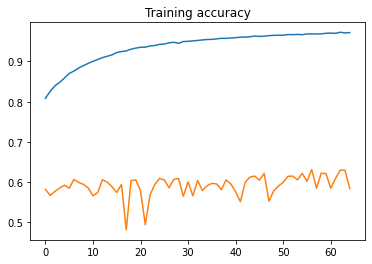

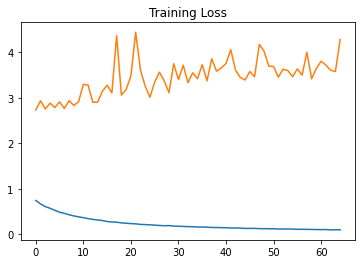

<Figure size 432x288 with 0 Axes>

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg